### Another Submission - adding more features to Random Forest. 

All this is taken from https://www.kaggle.com/creepykoala/titanic/study-of-tree-and-forest-algorithms/notebook 
I just write it in line by line by myself as it helps me learn and I can query things as I go. 

In [118]:
# Import libraries

import numpy as np
from numpy.random import random_integers
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import pointbiserialr, spearmanr
%matplotlib inline

print('Libraries Ready!')

Libraries Ready!


In [119]:
# Load training data

df = pd.read_csv('/home/sophie/projects/Titanic/data/train.csv', header=0)

People with stronger titles tend to have more help on board. Hence, we will categorize passengers based on titles.

In [120]:
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

# for each name, i.e. Braund, Mr. Owen Harris, we extract the title using x.split and strip and use it as a key to the 
# Title Dictionary. 
# x.split(',')[1] means split the string where the , is. Take the 2nd item. i.e. Mr. Owen Harris
# split('.')[0] means split by the . and take the first item.
# strip() to remove all the other characters. 
df['Title'] = df['Name'].apply(lambda x: Title_Dictionary[x.split(',')[1].split('.')[0].strip()])

print(df['Title'][0:5])
print(df['Name'][0:5])

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object
0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object


In [121]:
name = ['Braund, Mr. Owen Harris', 'Futrelle, Mrs. Jacques Heath (Lily May Peel)']
[name[1].split(',')[1].split('.')[0].strip()]
[name[1].split()]

[['Futrelle,', 'Mrs.', 'Jacques', 'Heath', '(Lily', 'May', 'Peel)']]

Include the ticket prefix as a new column

In [122]:
print (df['Ticket'][0:2])

0    A/5 21171
1     PC 17599
Name: Ticket, dtype: object


In [123]:
# Extract the letters from the beginning of each element of 'Ticket'
def Ticket_Prefix(s):
    s=s.split()[0] # if you don't include anything in split()
    if s.isdigit():
        return 'NoClue'
    else:
        return s
    
df['TicketPrefix'] = df['Ticket'].apply(lambda x: Ticket_Prefix(x))

print(df['TicketPrefix'][0:5])

0         A/5
1          PC
2    STON/O2.
3      NoClue
4      NoClue
Name: TicketPrefix, dtype: object


Fill in missing age with median age, based on Title, Pclass and Sex.

- Make a mask with non-null values for Age. Make a new dataframe out of this new mask.
- Make a groupby object from these values and calculate the median for each group

In [124]:
# Make an array where null values are False.
mask_Age = df.Age.notnull()

# New dataframe where all rows have a value for age. 
Age_Sex_Title_Pclass = df.loc[mask_Age, ["Age", "Title", "Sex", "Pclass"]]

# Groupby object to group by Title, Pclass and Sex
Filler_Ages_1 = Age_Sex_Title_Pclass.groupby(by = ["Title", "Pclass", "Sex"]).median()

# This moves both Sex and Pclass into column headers and does so in that order. 
Filler_Ages = Filler_Ages_1.Age.unstack(level = -1).unstack(level = -1)


In [125]:
print(Age_Sex_Title_Pclass[0:5])
print(len(df[mask_Age]))

    Age Title     Sex  Pclass
0  22.0    Mr    male       3
1  38.0   Mrs  female       1
2  26.0  Miss  female       3
3  35.0   Mrs  female       1
4  35.0    Mr    male       3
714


In [126]:
mask_Age = df.Age.isnull()  # A mask where null values are True

# New DataFrame with missing values for age
Age_Sex_Title_Pclass_missing = df.loc[mask_Age, ["Title", "Sex", "Pclass"]]

print(Age_Sex_Title_Pclass_missing[0:5])

   Title     Sex  Pclass
5     Mr    male       3
17    Mr    male       2
19   Mrs  female       3
26    Mr    male       3
28  Miss  female       3


In [127]:
print(Age_Sex_Title_Pclass[0:5])
print("Before unstacking---------")
print (Filler_Ages_1)
print("After unstacking---------")
print (Filler_Ages)

    Age Title     Sex  Pclass
0  22.0    Mr    male       3
1  38.0   Mrs  female       1
2  26.0  Miss  female       3
3  35.0   Mrs  female       1
4  35.0    Mr    male       3
Before unstacking---------
                        Age
Title   Pclass Sex         
Master  1      male     4.0
        2      male     1.0
        3      male     4.0
Miss    1      female  30.0
        2      female  24.0
        3      female  18.0
Mr      1      male    40.0
        2      male    31.0
        3      male    26.0
Mrs     1      female  40.0
        2      female  31.5
        3      female  31.0
Officer 1      female  49.0
               male    51.0
        2      male    46.5
Royalty 1      female  40.5
               male    40.0
After unstacking---------
Sex     female              male            
Pclass       1     2     3     1     2     3
Title                                       
Master     NaN   NaN   NaN   4.0   1.0   4.0
Miss      30.0  24.0  18.0   NaN   NaN   NaN
Mr        

- Make a function, Age_filler, which is applied to each of the missing dataframe.

In [128]:
# Look-up function for the calculated median ages. 
def Age_filler(row):
    if row.Sex == "female":
        age = Filler_Ages.female.loc[row["Title"], row["Pclass"]]
        return age
    elif row.Sex == "male":
        age = Filler_Ages.male.loc[row["Title"], row["Pclass"]]
        return age
    
# Make a new column on "missing" dataframe and add the median value to each row. 
Age_Sex_Title_Pclass_missing["Age"] = Age_Sex_Title_Pclass_missing.apply(Age_filler, axis= 1)

# reform the 'Age' column.
df["Age"] = pd.concat([Age_Sex_Title_Pclass["Age"], Age_Sex_Title_Pclass_missing["Age"]])

There is one missing Fare value to fill in:

In [129]:
# Filling in with the mean of all fares.
df['Fare'] = df['Fare'].fillna(value=df.Fare.mean())

Drop Cabin and Ticket.   
Combine SibSp and Parch to create FamilySize

In [130]:
df['FamilySize'] = df['SibSp'] + df['Parch']
df = df.drop(['Ticket', 'Cabin'], axis=1)

Now we will use dummy variables to transform the categorical data. 

In [131]:
# get_dummies splits up a column into two seperate columns of 1 and 0, where they are true or false. 
dummies_Sex = pd.get_dummies(df['Sex'], prefix='Sex')

print(df['Sex'][0:3])
print(dummies_Sex[0:3])

0      male
1    female
2    female
Name: Sex, dtype: object
   Sex_female  Sex_male
0         0.0       1.0
1         1.0       0.0
2         1.0       0.0


In [132]:
# Making dummies for the other categorical features
dummies_Embarked = pd.get_dummies(df['Embarked'], prefix= 'Embarked') 
dummies_Pclass = pd.get_dummies(df['Pclass'], prefix= 'Pclass')
dummies_Title = pd.get_dummies(df['Title'], prefix= 'Title')
dummies_TicketPrefix = pd.get_dummies(df['TicketPrefix'], prefix='TicketPrefix')

In [133]:
# Make new dataframes which have the dummies added on to the end.
df = pd.concat([df, dummies_Sex, dummies_Embarked, dummies_Pclass, dummies_Title, dummies_TicketPrefix], axis=1)

# Drop the categorical data
df = df.drop(['Sex','Embarked','Pclass','Title','Name','TicketPrefix'], axis=1)

Finally, set PassengerId as the index:

In [134]:
df = df.set_index(['PassengerId'])

df.head()

,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,TicketPrefix_SOTON/O.Q.,TicketPrefix_SOTON/O2,TicketPrefix_SOTON/OQ,TicketPrefix_STON/O,TicketPrefix_STON/O2.,TicketPrefix_SW/PP,TicketPrefix_W./C.,TicketPrefix_W.E.P.,TicketPrefix_W/C,TicketPrefix_WE/P
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,38.0,1,0,71.2833,1,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,26.0,0,0,7.9250,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,35.0,1,0,53.1000,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,35.0,0,0,8.0500,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Feature Selection

To select features we will correlate each feature against Survived. We need to use different algorithms for the different data types:

- Spearman-Rank correlation for nominal vs nominal data
- Point-Biserial correlation for nominal vs continuous data

In [135]:
# Put the column names into a list called columns
columns = df.columns.values

# initiate lists to store results
param = []
correlation = []
abs_corr=[]

In [136]:
print(len(columns))
#[print(type(df[c])) for c in columns][0:10]
[print("%s"%c) for c in columns[0:10]]

64
Survived
Age
SibSp
Parch
Fare
FamilySize
Sex_female
Sex_male
Embarked_C
Embarked_Q


[None, None, None, None, None, None, None, None, None, None]

In [137]:
for c in columns:
    # Check if binary or continuous
    if len(df[c].unique())<=2:
        corr = spearmanr(df['Survived'], df[c])[0]   # apply spearmanr if
    else:
        corr = pointbiserialr(df['Survived'], df[c])[0]
    
    param.append(c) # name of feature
    correlation.append(corr) # associated correlation
    abs_corr.append(abs(corr))# get rid of -ve values

In [138]:
print(correlation[0:5])
print(abs_corr[0:5])

[1.0, -0.062899950141403885, -0.035322498885735583, 0.081629407083483485, 0.25730652238496243]
[1.0, 0.062899950141403885, 0.035322498885735583, 0.081629407083483485, 0.25730652238496243]


In [139]:
# Create dataFrame for visualisation
param_df = pd.DataFrame({'correlation':correlation, 'parameter':param, 'abs_corr':abs_corr})

# Sort by absolute correlation
param_df = param_df.sort_values(by=['abs_corr'], ascending=False)

# Set parameter name as index
param_df = param_df.set_index('parameter')

print(len(param_df))
param_df[0:10]

64


,abs_corr,correlation
parameter,,
Survived,1.000000,1.000000
Title_Mr,0.549199,-0.549199
Sex_male,0.543351,-0.543351
Sex_female,0.543351,0.543351
Title_Mrs,0.344935,0.344935
Title_Miss,0.332795,0.332795
Pclass_3,0.322308,-0.322308
Pclass_1,0.285904,0.285904
Fare,0.257307,0.257307


In [140]:
print(df.isnull().sum())

Survived                   0
Age                        0
SibSp                      0
Parch                      0
Fare                       0
FamilySize                 0
Sex_female                 0
Sex_male                   0
Embarked_C                 0
Embarked_Q                 0
Embarked_S                 0
Pclass_1                   0
Pclass_2                   0
Pclass_3                   0
Title_Master               0
Title_Miss                 0
Title_Mr                   0
Title_Mrs                  0
Title_Officer              0
Title_Royalty              0
TicketPrefix_A./5.         0
TicketPrefix_A.5.          0
TicketPrefix_A/4           0
TicketPrefix_A/4.          0
TicketPrefix_A/5           0
TicketPrefix_A/5.          0
TicketPrefix_A/S           0
TicketPrefix_A4.           0
TicketPrefix_C             0
TicketPrefix_C.A.          0
                          ..
TicketPrefix_F.C.C.        0
TicketPrefix_Fa            0
TicketPrefix_LINE          0
TicketPrefix_N

Now that we have our correlation, we can use the Decision Tree classifier to see the score against feature space

In [141]:
scoresCV = []
scores = []

# Loop over each of the 64 different parameters
for i in range(1, len(param_df)):
    
    # Make a new dataframe for each feature(selected by df[])
    new_df = df[param_df.index[0:i+1].values]
    
    # .ix supports mixed labels and integer. It can do what .loc and .iloc. both do.
    # X is abs_corr
    X = new_df.ix[:,1::]
    #print(X)
    
    # y is corr
    y = new_df.ix[:,0]
    
    # initialise a DecisionTreeClassifier object
    clf = DecisionTreeClassifier()
    
    # cross_val_score, returns: Array of scores of the estimator for each run of the cross validation.
    # (estimators, data-to-fit, target-variable-to-predict, cv(determines the cross-validation splitting strategy))
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv = 10)
    
    # save the mean of all the runs
    scores.append(np.mean(scoreCV))


In [142]:
new_df = df[param_df.index[0:1].values]
print(list(new_df))
new_df = df[param_df.index[0:3].values]
print(list(new_df))
print(len(scores))

['Survived']
['Survived', 'Title_Mr', 'Sex_male']
63


Plot the scores for different numbers of features

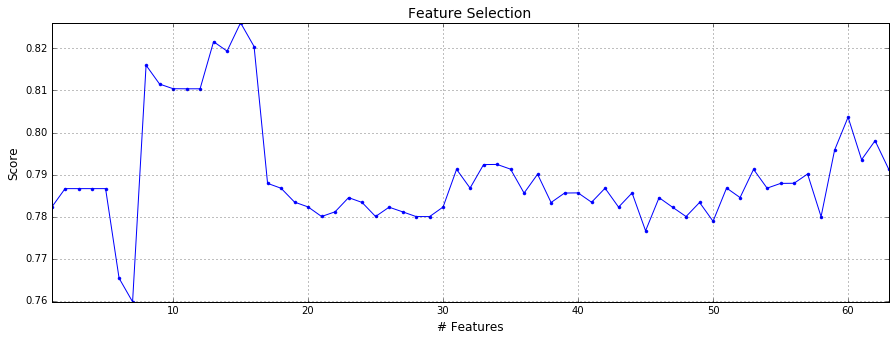

In [143]:
plt.figure(figsize=(15,5))
plt.plot(range(1,len(scores)+1), scores, '.-')
plt.axis("tight")
plt.title('Feature Selection', fontsize=14)
plt.xlabel('# Features', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid();

Does the cross validation score not depend on WHICH features are selected? We put the parameters in order of most highly correlated to lowest. 

Based on the plot, a feature space of 10 dimensions (the top 10 most highly correlating features) provides the most reliable result while avoiding overfit.

In [144]:
best_features=param_df.index[1:10+1].values # ignore the first column which is survives
print('Best features:\t',best_features)

Best features:	 ['Title_Mr' 'Sex_male' 'Sex_female' 'Title_Mrs' 'Title_Miss' 'Pclass_3'
 'Pclass_1' 'Fare' 'Embarked_C' 'Embarked_S']


Looking at them in histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fd9d28d30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8fd9f974a8>]], dtype=object)

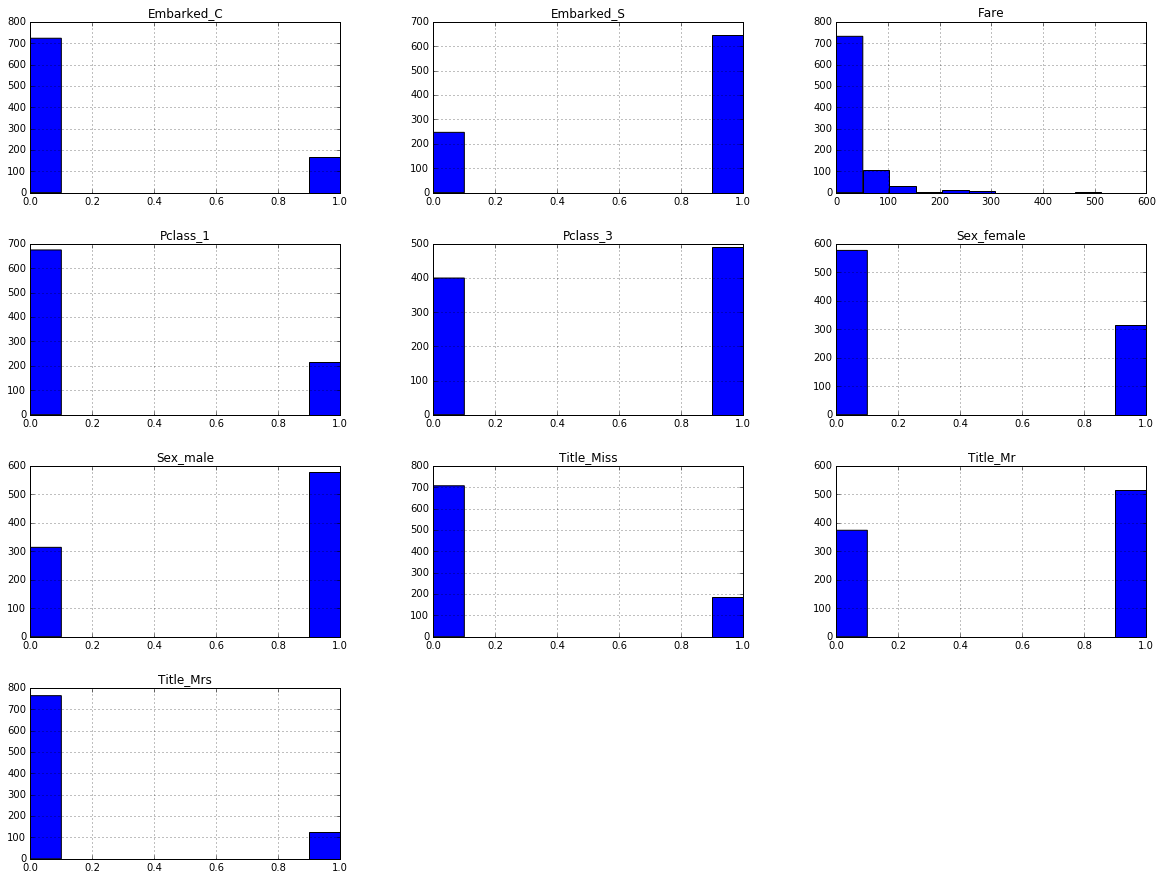

In [145]:
df[best_features].hist(figsize=(20,15))

Creating the train and test datasets within the original training data to experiment with different parameters.

In [151]:
X = df[best_features]
y = df['Survived']

# Add X to y for a dataframe ready for the final model training. 

train_final = pd.concat([X,y], axis=1)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44)

# Don't actually need these now.
# Add y_train to X_train
train = pd.concat([X_train, y_train], axis=1)
print(list(train))

# Add y_test to X_test
test = pd.concat([X_test, y_test], axis=1)
print(list(test))

['Title_Mr', 'Sex_male', 'Sex_female', 'Title_Mrs', 'Title_Miss', 'Pclass_3', 'Pclass_1', 'Fare', 'Embarked_C', 'Embarked_S', 'Survived']
['Title_Mr', 'Sex_male', 'Sex_female', 'Title_Mrs', 'Title_Miss', 'Pclass_3', 'Pclass_1', 'Fare', 'Embarked_C', 'Embarked_S', 'Survived']


In [153]:
print(len(train))
print(len(test)) # saves about 40% for training. 

596
295


In [154]:
print(list(X_train))
print(list(X_test))
print(X_train.index[0:10])

# Passenger ID is the index 

['Title_Mr', 'Sex_male', 'Sex_female', 'Title_Mrs', 'Title_Miss', 'Pclass_3', 'Pclass_1', 'Fare', 'Embarked_C', 'Embarked_S']
['Title_Mr', 'Sex_male', 'Sex_female', 'Title_Mrs', 'Title_Miss', 'Pclass_3', 'Pclass_1', 'Fare', 'Embarked_C', 'Embarked_S']
Int64Index([827, 106, 189, 595, 588, 633, 395, 44, 77, 835], dtype='int64', name='PassengerId')


Store the training dataset for later use.

In [155]:
#Output this to csv to be read in for predicting values.

train_final.to_csv('/home/sophie/projects/Titanic/data/clean_train_53.csv', sep = " ")

### Decision Tree

Analysing the different parameters of Decision Trees

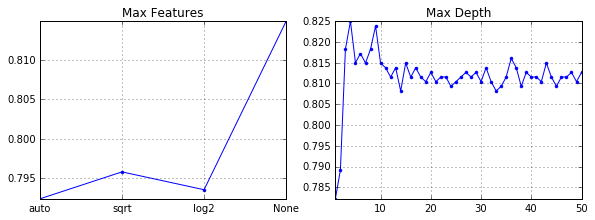

In [103]:
plt.figure(figsize=(15,7))

#Max Features
plt.subplot(2,3,1) # first of the subplots
feature_param = ['auto','sqrt','log2',None]  # testing the keywords that can be given to max_features
scores=[]

for feature in feature_param:  # loop over each keyword and add result to scores=[]
    clf = DecisionTreeClassifier(max_features=feature)  # initiate the model, with a particular number of features
    clf.fit(X_train,y_train)  # fit the data to the model
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10) # get the cross validation score for this 
                                                                          # particular number of features. This is done
                                                                          # 10 times (cv = 10)
    scores.append(np.mean(scoreCV))  # append the mean of the 10 scores to scores list.

plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Depth
plt.subplot(2,3,2)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

No need to set the maximum number of features. Our initial engineering which narrowed down the section to 10 appears to be better than any of the other keyword options.
Setting a maximum depth for the tree of 3 appears to be optimal. 

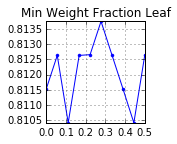

In [104]:
#Min Weight Fraction Leaf
plt.subplot(2,3,5)
feature_param = np.linspace(0,0.5,10) # create 10 values between 0 and 0.5
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#This plot changes everytime. 

In [34]:
print(feature_param)

[ 0.          0.05555556  0.11111111  0.16666667  0.22222222  0.27777778
  0.33333333  0.38888889  0.44444444  0.5       ]


This changes a lot every time you run the code. Will leave this one out. 

Now, get the other optimal values, without making the plots

In [212]:
#Min Samples Split
feature_param = range(1,51)
scores=[]
scores_std=[]

scores2=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_split =feature)
    clf.fit(X,y) # used the whole training set.
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
    scores_std.append(np.std(scoreCV))
    
    # less recommended method as information from the test set can "leak" into the training set, if you tweak the 
    # parameters.
    scores2.append(clf.score(X_test, y_test))
    
max_index = scores.index(max(scores)) 
max_index2 = scores2.index(max(scores2))

print("optimal min_samples_split at %d" %max_index)

print("Mean score is %f with std %f" %(max(scores), scores_std[max_index]))
print(["%.3f " %s for s in scores_std])

optimal min_samples_split at 14
Mean score is 0.820522 with std 0.045472
['0.035 ', '0.035 ', '0.034 ', '0.030 ', '0.034 ', '0.032 ', '0.036 ', '0.036 ', '0.037 ', '0.037 ', '0.041 ', '0.044 ', '0.042 ', '0.042 ', '0.045 ', '0.048 ', '0.048 ', '0.049 ', '0.046 ', '0.046 ', '0.048 ', '0.044 ', '0.042 ', '0.044 ', '0.042 ', '0.042 ', '0.040 ', '0.044 ', '0.046 ', '0.048 ', '0.046 ', '0.046 ', '0.046 ', '0.048 ', '0.048 ', '0.048 ', '0.048 ', '0.048 ', '0.048 ', '0.048 ', '0.048 ', '0.048 ', '0.048 ', '0.049 ', '0.050 ', '0.050 ', '0.051 ', '0.051 ', '0.051 ', '0.051 ']


In [178]:
# How different are the scores if I use clf.score, or apply cross_validation.cross_val_score?
print(max_index)
print(max_index2)


21
8


Better to use 

In [94]:
#Min Samples Leaf
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))

max_index = scores.index(max(scores))    
print("optimal min_samples_leaf at %d" %max_index)

# If you run this several times it changes between 4 and 10. Maybe try one or the other then switch.


optimal min_samples_leaf at 4


In [95]:
#Min Weight Fraction Leaf
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
    
max_index = scores.index(max(scores))    
print("optimal min_weight_fraction_leaf at %d" %max_index)

# This changes everytime you do it. Not a stable reliable parameter.

optimal min_weight_fraction_leaf at 5


In [102]:
#Max Leaf Nodes
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))

max_index = scores.index(max(scores))    
print("optimal max_leaf_nodes at %d" %max_index)    

# Consistently gives 6

optimal max_leaf_nodes at 6


#### Final precition of score using a combination of the features above

In [158]:
clf = DecisionTreeClassifier(max_depth = 3, min_samples_split = 14, min_samples_leaf = 4, max_leaf_nodes = 6)
clf.fit(X_train,y_train)
scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
score = np.mean(scoreCV)

print(score)

0.8159505164


#### So, using Decision Trees with very specific parameters I can get a score up to 0.816? Nope, not that high.